# Individual Elo ratings for players in SHL season 2014-15

Analysis is based on http://nhlnumbers.com/2014/3/18/elo-for-evaluating-players.

We consider each goal a win for the group of players scoring the goal, and a loss for the group of players letting the goal in. The average rating of each team's players on the ice is used as a proxy for their Elo scores, but changes are applied individually.

In [2]:
%pylab inline
import pandas as pd

pylab.rcParams['figure.figsize'] = (16.25, 10.)

Populating the interactive namespace from numpy and matplotlib


### Load game statistics

In [12]:
%%bash
# make liveevents

In [4]:
%time
import json
from glob import glob

games = []

for liveevents in glob('data/shl.se/shl-arena/*/liveevents'):
    with open(liveevents + '/playerstats') as f:
        playerstats = json.load(f)
        
    with open(liveevents + '/0') as f:
        gamestats = json.load(f)
        
    games.append({'playerstats': playerstats, 'gamestats': gamestats})

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


## Elo calculation

We use the same parameters as in http://nhlnumbers.com/2014/3/18/elo-for-evaluating-players: 

* initial Elo rating = 1000, and 
* K = 32.

Limitations:

* We only consider games in the regular season.
* We also only consider games scored during period 1, 2 and 3 where both teams are in full strength.
* Goalkeepers are excluded from the calculation.

In [5]:
from collections import defaultdict

initial_rating = 1000.
K = 32
player_ratings = defaultdict(lambda: initial_rating)

In [6]:
rating_changes = []

for game in games:
    # Get both teams
    game_teams = set(map(game['playerstats']['Recap']['Total'].get, ['awayTeamId', 'homeTeamId']))
    
    for event in game['gamestats']['Events']:
        # Skip non-goal events
        if event['class'] != 'Goal':
            continue
            
        [extra, period, scoring_team, time] = map(event.get, ['extra', 'period', 'team', 'realTime'])

        # Skip OT
        if period not in [1, 2, 3]:
            continue

        timestamp = pd.to_datetime(time, format='%Y%m%d%H%M%S')
        other_team = (game_teams - set([scoring_team])).pop()
        
        # POP = players on the ice for the scoring team
        # NEP = other team's players
        pop = map(int, extra['pop'][len('POP: '):].split(', '))
        nep = map(int, extra['nep'][len('NEP: '):].split(', '))

        # Only 5 v 5
        if not (len(pop) == 6 and len(nep) == 6):
            continue

        # Find identifiers of all players, skip goalies
        RAs = [s['player']
               for p in pop
               for s in game['playerstats']['PlayerStatistics']
               if s['team'] == scoring_team and s['jersey'] == p and s['position'] != 'GK']
        RBs = [s['player']
               for p in nep
               for s in game['playerstats']['PlayerStatistics']
               if s['team'] == other_team and s['jersey'] == p and s['position'] != 'GK']

        # Take the average rating of both team's players
        RA = np.mean([player_ratings[a] for a in RAs])
        RB = np.mean([player_ratings[b] for b in RBs])

        # The scoring team "won" this            
        SA = 1  # Win=1, Draw=.5, Loss=0
        SB = 0

        # Expected
        EA = 1. / (1 + 10**((RB - RA) / 400.))
        EB = 1. / (1 + 10**((RA - RB) / 400.))

        # Update ratings    
        for a in RAs:
            player_ratings[a] += K * (SA - EA)
            rating_changes.append({'time': timestamp,
                                   'player': a,
                                   'elo': player_ratings[a]})

        for b in RBs:
            player_ratings[b] += K * (SB - EB)
            rating_changes.append({'time': timestamp,
                                   'player': b,
                                   'elo': player_ratings[b]})

In [7]:
# Each player's final Elo rating
players = pd.concat([pd.DataFrame([{k: p[k] for k in ['player', 'team', 'firstName', 'familyName']}
                                   for p in game['playerstats']['PlayerStatistics']])
                     for game in games]) \
              .set_index('player') \
              .dropna() \
              .drop_duplicates() \
              .join(pd.DataFrame(list(player_ratings.iteritems()),
                                 columns=['player', 'elo']).set_index('player'))

## Top rated players

In [8]:
top_players = players.sort('elo', ascending=False)
top_players.head(5)

,familyName,firstName,team,elo
player,,,,
1727,Rosén,Robert,VLH,1249.126932
2688,Kiiskinen,Tuomas,VLH,1242.588160
2637,Lehkonen,Artturi,FHC,1232.262526
2602,Kabanov,Kirill,SAIK,1229.116822
1197,Figren,Robin,FHC,1206.838350


The top two players, Rosén and Kiiskinen, are both from the champions Växjö Lakers.

## Bottom rated players

In [14]:
top_players.sort('elo', ascending=True).head(5)

,familyName,firstName,team,elo
player,,,,
390,Frögren,Jonas,LIF,693.185930
2467,Händemark,Fredrik,LIF,751.958318
428,Eriksson,Joakim,DIF,773.904597
2227,Himelfarb,Eric,LIF,783.524772
2466,Forsberg,Tobias,LIF,785.723373


Many of the lowest rated players are from less prominent teams, but they also have a lot of ice time, so their low Elo rating may be misrepresentative of their abilities. [Joakim Eriksson](http://shl.se/statistics/profile/gamelog/428/2014) of DIF plays averages more than 20 minutes per game.

## Player ratings over time

In [10]:
player_ratings_ts = pd.pivot_table(pd.DataFrame(rating_changes),
                                   index='time', columns='player', values='elo')

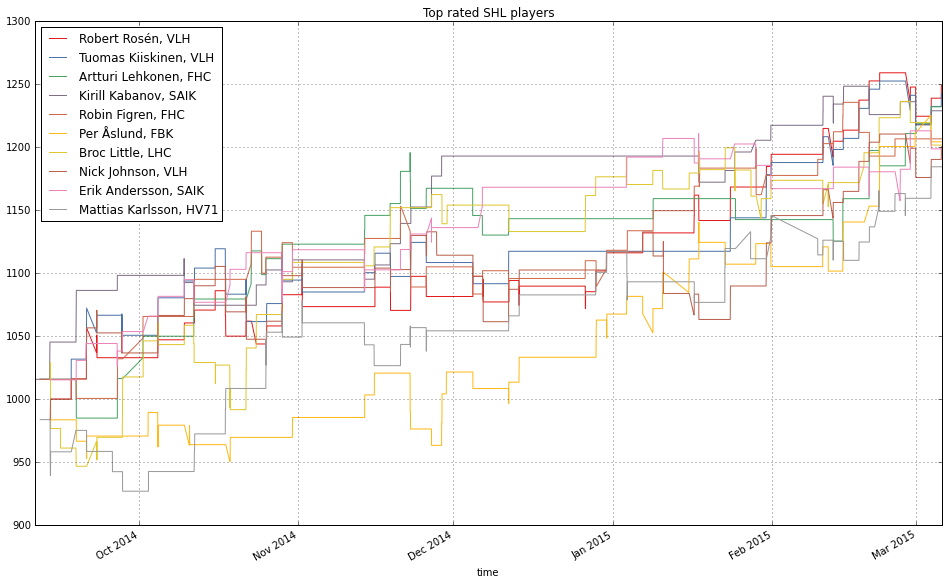

In [11]:
player_ratings_ts[top_players.head(10).index] \
    .ffill() \
    .plot(title='Top rated SHL players', cmap='Set1')
plt.legend(top_players.head(10).index.map(lambda p: u'{firstName} {familyName}, {team}'.format(**players.ix[p])),
           loc='upper left')

## Risk to reward ratio

For fun, we consider using the ex-post [Sharpe ratio](http://en.wikipedia.org/wiki/Sharpe_ratio) to find players who have a good risk to reward ratio, e.g. players who consistently perform well. Hypothesis: they are also good defensively.

In [34]:
player_ratings_rets = player_ratings_ts.pct_change()
player_ratings_sharpe = player_ratings_rets.mean() / player_ratings_rets.std()
top_sharpe = player_ratings_sharpe \
    .sort(inplace=False, ascending=False) \
    .replace([np.inf, -np.inf], np.nan) \
    .dropna() \
    .head(10)

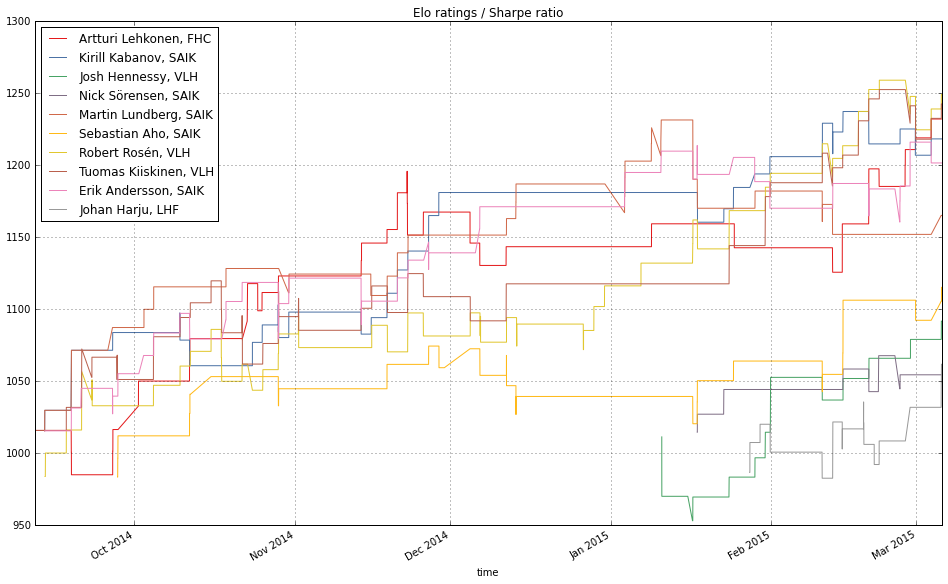

In [35]:
player_ratings_ts[top_sharpe.index].ffill() \
    .plot(title='Elo ratings / Sharpe ratio', cmap='Set1')
plt.legend(top_sharpe.index.map(lambda p: u'{firstName} {familyName}, {team}'.format(**players.ix[p])),
           loc='upper left')

## Average rating of each team's roster

In [36]:
players[['team', 'elo']].groupby('team').mean().sort('elo', ascending=False)

,elo
team,
SAIK,1058.268486
VLH,1042.115273
OHK,1035.549596
LHC,1018.822758
FHC,1010.400652
LHF,1008.351541
FBK,1006.821682
MODO,985.982951
HV71,981.050879


Not quite in line with the team Elo ratings. Are the teams that have a higher team Elo rating than average player's Elo rating a team "better than the sum of its parts"? Or is it well coached?